In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [87]:
df = pd.read_excel('results/SA/output_100e.xlsx')
df = df.drop(columns=['neighborhood_size', 'neighbor_deviation_scale', 'vessel_time_window', 'affected_movements', 'time_interval','epochs'])
# rename number of movements to movements reached
df = df.rename(columns={'number of movements': 'movements reached'})
col_names = df.columns
print(col_names)

df_instances = pd.read_excel('results/instanceData_200.xlsx')
col_names_instances = df_instances.columns
print(col_names_instances)
# merge the two dataframes
df = pd.merge(df, df_instances, on='instance')

# recalculate the objective function
movements_factor = 0.001
headway_factor = 0.001
df['objective_function'] = df['average delay'] \
                           + df['movements reached'] * movements_factor + df['number_of_headways'] * headway_factor
print(df['objective_function'], df['average delay'])

Index(['instance', 'movements reached', 'median delay', 'average delay',
       'obj_val', 't0', 'alpha', 'valid_solution'],
      dtype='object')
Index(['instance', 'number_of_movements', 'number_of_headways',
       'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
       'average_time_between_movements', 'average_travel_time'],
      dtype='object')
0      1.469833
1      1.424000
2      1.140667
3      1.278167
4      1.007333
         ...   
995    0.971667
996    0.938333
997    1.758333
998    1.005000
999    0.701667
Name: objective_function, Length: 1000, dtype: float64 0      1.045833
1      1.000000
2      0.716667
3      0.854167
4      0.583333
         ...   
995    0.346667
996    0.313333
997    1.133333
998    0.380000
999    0.076667
Name: average delay, Length: 1000, dtype: float64


In [88]:
feature_cols= ['t0', 'alpha',
               'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
                'average_time_between_movements', 'average_travel_time']

X = df[feature_cols].values
y = df['objective_function'].values

In [89]:
# import warnings
# warnings.filterwarnings("ignore")
# 
# # Convert data to torch tensors
# class Data(Dataset):
#     def __init__(self, X, y):
#         self.X = X.astype(np.float32)
#         self.y = y.astype(np.float32)
#         # or directly from pandas to torch
#         X = torch.from_numpy(X)
#         y = torch.from_numpy(y)
#         self.len = self.X.shape[0]
#        
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
#    
#     def __len__(self):
#         return self.len
# 
# # Define batch size
# batch_size = 32
# 
# # Instantiate training and test data
# train_data = Data(X_train_scaled, y_train_scaled)
# train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# 
# test_data = Data(X_test_scaled, y_test_scaled)
# test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# 
# # Check it's working
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     break


In [90]:
# define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
model = Net()
# to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [91]:
import tqdm

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 40  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = model.state_dict().copy()
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE: 0.07
RMSE: 0.27


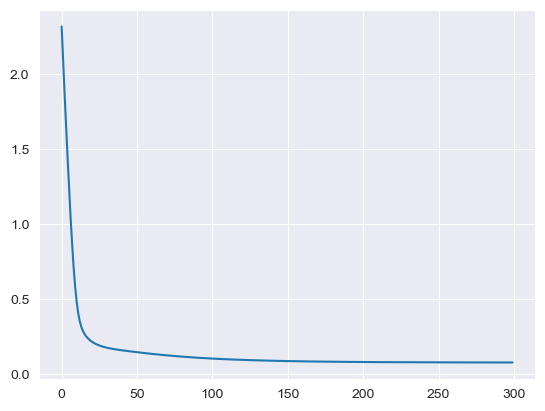

In [92]:
# plot the loss
import matplotlib.pyplot as plt

model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [93]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples from the original test set
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[97.          0.68838562 21.         19.          0.814836    0.53866916
 23.16666667  1.1031746   2.07936508] -> [1.242668] (expected [1.3151429])
[426.           0.75557212  17.          16.           0.86111111
   0.5816407   19.83333333   1.16666667   2.10784314] -> [1.2433646] (expected [0.8802157])
[477.           0.79286311  20.          18.           0.83510168
   0.51727151  38.08333333   1.90416667   1.955     ] -> [1.3114173] (expected [1.0261667])
[129.           0.83899113  21.          19.           0.80725309
   0.54296034  18.33333333   0.87301587   2.23015873] -> [1.3695228] (expected [1.1879841])
[244.           0.69969322  24.          23.           0.76478261
   0.50578664  21.5          0.89583333   2.05902778] -> [1.5018103] (expected [1.6510834])


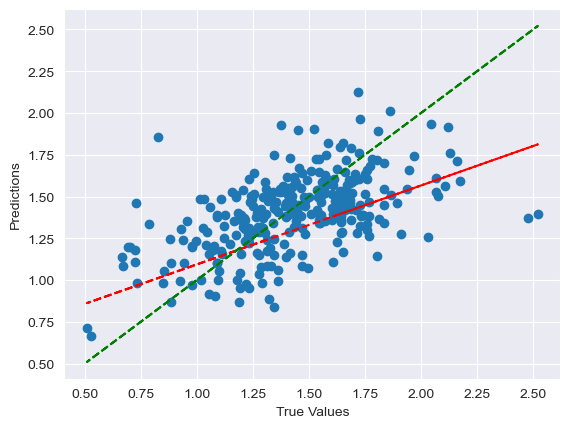

In [94]:
# plot the predictions as a scatter plot
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
# plot the line of best fit
z = np.polyfit(y_test[0], y_pred[0], 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()



In [95]:
# get the importance of each feature
importance = model.fc1.weight.data.numpy()
# summarize feature importance
for i,v in enumerate(importance[0]):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.16279
Feature: 1, Score: -0.04942
Feature: 2, Score: 0.14793
Feature: 3, Score: 0.05046
Feature: 4, Score: 0.26305
Feature: 5, Score: -0.04709
Feature: 6, Score: 0.07518
Feature: 7, Score: 0.17553
Feature: 8, Score: 0.35536


In [96]:
# save the model
torch.save(model.state_dict(), 'results/SA/models/NN_model_100e.pth')